In [32]:
#import pdb; pdb.set_trace()
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pdp

# Jupyter Notebookの中でインライン表示する場合の設定（これが無いと別ウィンドウでグラフが開く）
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/probspace')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")
train.head(10)

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
4,4,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
5,5,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
6,6,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
7,7,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
8,8,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0
9,9,200000,2,3,2,34,0,0,2,0,0,-1,11073,9787,5535,2513,1828,3731,2306,12,50,300,3738,66,0


In [0]:
columns = ["id", "credit", "gender", "education", "marrage", "age"]
columns += [f"payment_{i}" for i in range(9,3,-1)]
columns += [f"claim_{i}" for i in range(9,3,-1)]
columns += [f"advance_{i}" for i in range(9,3,-1)]
train.columns = columns + ["target"]
test.columns = columns

In [0]:
'''
#年齢台の特徴量
train["age_cat"] = (np.floor(train["age"]/10)*10).astype(np.int64)
test["age_cat"] = (np.floor(test["age"]/10)*10).astype(np.int64)
'''

column_names = [f"payment_{i}" for i in range(9,3,-1)]

train["payment"] =  0
test["payment"] =  0

for column_name in column_names:
    train.loc[train[column_name] < 0, column_name] = 0
    test.loc[test[column_name] < 0, column_name] = 0
    
    

#row は遅い
for index, row in train.iterrows():    
    if any(row[column_names]) == True:
      train.loc[index, "payment"] = 1
      
for index, row in test.iterrows():    
    if any(row[column_names]) == True:
      test.loc[index, "payment"] = 1

   


In [36]:
"""
bad_pred_data = pd.DataFrame()
for i in range(len(train)-1):
  if train.loc[i, "payment"] != train.loc[i, "target"]:
    bad_pred_data 
"""   
#過去の支払い遅れが一回だけの場合は今回支払う可能性が高そう　1回だけ支払い遅れまで０か否かコラム
#直近の支払い遅れは影響ありそう　payment_9,8 が0か否か

bad_pred_data = train[train["payment"] != train["target"]]
bad_pred_data.head(100)

,id,credit,gender,education,marrage,age,payment_9,payment_8,payment_7,payment_6,payment_5,payment_4,claim_9,claim_8,claim_7,claim_6,claim_5,claim_4,advance_9,advance_8,advance_7,advance_6,advance_5,advance_4,target,payment
7,7,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,1
9,9,200000,2,3,2,34,0,0,2,0,0,0,11073,9787,5535,2513,1828,3731,2306,12,50,300,3738,66,0,1
10,10,260000,2,1,2,51,0,0,0,0,0,2,12261,21670,9966,8517,22287,13668,21818,9966,8583,22301,0,3640,0,1
13,13,50000,2,3,3,23,1,2,0,0,0,0,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,1
15,15,360000,2,1,1,49,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16,16,180000,2,1,2,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19,19,450000,2,1,1,40,0,0,0,0,0,0,5512,19420,1473,560,0,0,19428,1473,560,0,0,1128,1,0
33,33,280000,1,1,2,31,0,0,2,0,0,0,498,9075,4641,9976,17976,9477,9075,0,9976,8000,9525,781,0,1
38,38,40000,2,1,2,30,0,0,0,2,0,0,18927,21295,25921,25209,26636,29197,3000,5000,0,2000,3000,0,0,1
39,39,210000,1,1,2,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
train["payment_89"] = 0
test["payment_89"] = 0
train["under_one_miss"] = 0
test["under_one_miss"] = 0

for i in range(len(train)-1):
  if train.loc[i, "payment_9"] != 0 or train.loc[i, "payment_8"] != 0:
    train.loc[i, "payment_89"] = 1

  if pd.Series([0]).map(train.loc[i,column_names].value_counts() <= 4)[0] == True:
    train.loc[i,"under_one_miss"] = 1
    
for i in range(len(test)-1):
  if test.loc[i, "payment_8"] != 0 and test.loc[i, "payment_9"] != 0:
    test.loc[i, "payment_89"] = 1 
  if pd.Series([0]).map(test.loc[i,column_names].value_counts() <= 4)[0] == True:
    test.loc[i,"under_one_miss"] = 1


In [40]:
test.head(20)

,id,credit,gender,education,marrage,age,payment_9,payment_8,payment_7,payment_6,payment_5,payment_4,claim_9,claim_8,claim_7,claim_6,claim_5,claim_4,advance_9,advance_8,advance_7,advance_6,advance_5,advance_4,payment,payment_89,under_one_miss
0,0,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0
1,1,630000,2,2,2,41,0,0,0,0,0,0,12137,6500,6500,6500,6500,2870,1000,6500,6500,6500,2870,0,0,0,0
2,2,320000,1,1,1,49,0,0,0,0,0,0,253286,246536,194663,70074,5856,195599,10358,10000,75940,20000,195599,50000,0,0,0
3,3,120000,2,2,1,39,0,0,0,0,0,0,316,316,316,0,632,316,316,316,0,632,316,0,0,0,0
4,4,50000,2,3,2,30,0,0,0,0,0,0,22541,16138,17163,17878,18931,19617,1300,1300,1000,1500,1000,1012,0,0,0
5,5,500000,1,1,1,58,0,0,0,0,0,0,13709,5006,31130,3180,0,5293,5006,31178,3180,0,5293,768,0,0,0
6,6,280000,2,1,2,39,0,0,0,0,0,0,7524,0,3968,3868,0,0,0,3968,0,0,0,0,0,0,0
7,7,360000,1,1,1,43,0,0,0,0,0,0,3967,8322,3394,6451,26370,9956,8339,3394,12902,27000,0,68978,0,0,0
8,8,80000,2,2,1,36,0,0,0,0,0,0,6108,2861,3277,3319,1150,1150,2861,3279,3319,1150,1150,1035,0,0,0
9,9,80000,2,2,1,23,1,2,3,2,0,0,9168,10522,10205,9898,10123,12034,1650,0,0,379,2091,1,1,1,1


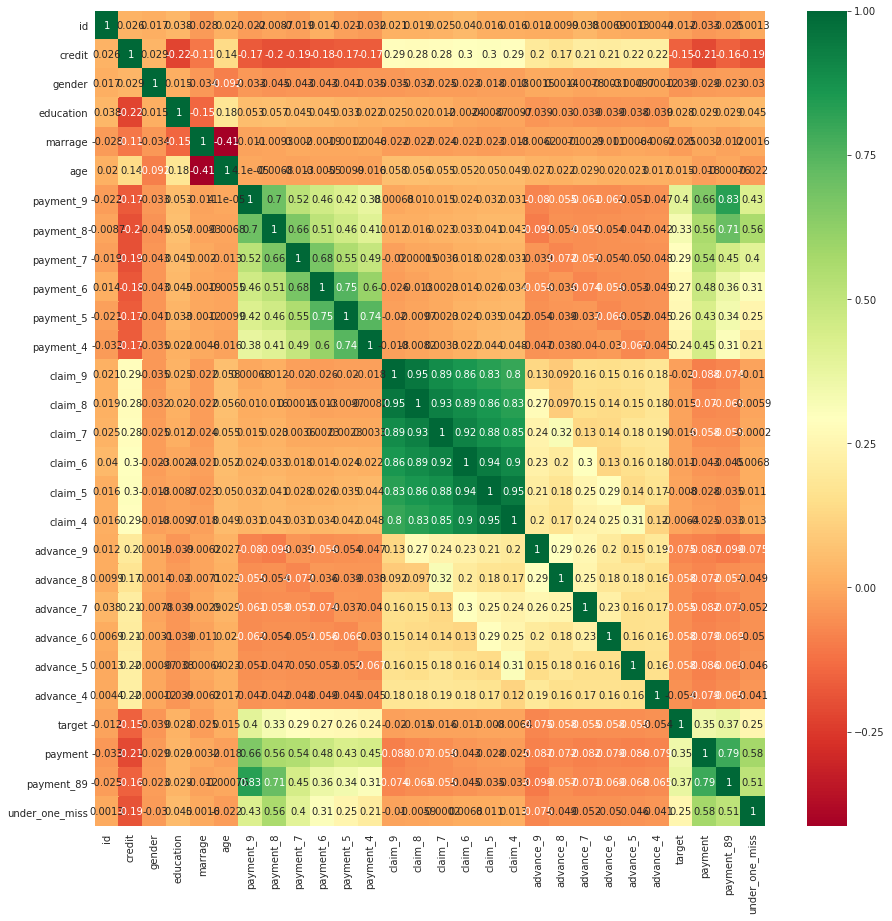

In [41]:
#とりあえず相関を見てみる
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["target"])>-10]
plt.figure(figsize=(15,15))
g = sns.heatmap(train[top_corr_features].corr(), annot = True, cmap="RdYlGn")

In [0]:
#NaNの対処
nuls = pd.DataFrame(train.isnull().sum().sort_values(ascending = False)[:10])
nuls.columns = ['Null Count']
nuls.index.name = 'Feature'
nuls

In [0]:
pdp.ProfileReport(train)

In [0]:
train.dtypes
#gender education age target をカテゴリ型に変換したい

In [0]:
#トレーニングデータの分割
y = train.target 
X = train.drop(['id','target'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.20)

In [0]:
#xgb 0830 RMSE: 0.1801851851851852
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb = xgb.XGBClassifier(max_depth=7, learning_rate=0.05, n_estimators=100)


model_xgb.fit(X_train, y_train, verbose=False)
preds = model_xgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18074074074074073 


In [43]:
#xgb 0834 RMSE: 0.1814814814814815  
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb = xgb.XGBClassifier(max_depth=2, learning_rate=0.05, n_estimators=100)


model_xgb.fit(X_train, y_train, verbose=False)
preds = model_xgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18203703703703702 


In [22]:
model_xgb = xgb.XGBClassifier(max_depth=2, learning_rate=0.05, n_estimators=100, max_leaves = 2)


model_xgb.fit(X_train, y_train, verbose=False)
preds = model_xgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18407407407407408 


In [44]:
#xgbテストデータで予測したtarget値をCSVに出力
XGBMd = model_xgb.predict(test.drop(['id'], axis=1))

submit= pd.DataFrame()
submit['ID'] = test.id
submit['Y'] = XGBMd

submit.to_csv('xgb_submit.csv', index=False)
print('XGB submission file created')

XGB submission file created


In [0]:
#light gbm　0832 RMSE: 0.1787037037037037  
#we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(max_depth=7, learning_rate=0.05, num_leaves=31, n_estimators=100)


model_lgb.fit(X_train, y_train, verbose=False)
preds = model_lgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.1787037037037037  


In [14]:
#light gbm　0832 RMSE: 0.1787037037037037  
#we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(max_depth=2, learning_rate=0.05, num_leaves=2, n_estimators=100)


model_lgb.fit(X_train, y_train, verbose=False)
preds = model_lgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18314814814814814 


In [0]:
#lgbテストデータで予測したtarget値をCSVに出力
LGBMd = model_lgb.predict(test.drop(['id'], axis=1))

submit= pd.DataFrame()
submit['ID'] = test.id
submit['Y'] = LGBMd

submit.to_csv('lgb_submit.csv', index=False)
print('LGB submission file created')

LGB submission file created
